In [ ]:
---
title: "NYCTaxi"
author: "권진원"
format: dashboard
execute:
  enabled: true
  cache: false
  freeze: false
---


In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import json
import requests
import pickle

In [3]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [19]:
# | output: false
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)
df_small = df[::100].reset_index(drop=True)

day_mapping = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}

df['요일'] = df['dayofweek'].map(day_mapping)
df.rename(columns={'pickup_hour': 'pickup_시간'}, inplace=True)


tidydata1 = df.pivot_table(
    index = 'pickup_시간',
    columns = '요일',
    values = 'speed',
    aggfunc = 'mean'
).stack().reset_index().rename({0:'평균속력'},axis=1)

tidydata2 = df.pivot_table(
    index = 'pickup_시간',
    columns = '요일',
    values = 'dist',
    aggfunc = 'mean'
).stack().reset_index().rename({0:'평균이동거리'},axis=1)

tidydata3 = df_small.assign(
    speed_cut = pd.qcut(df_small.speed,4)
).sort_values('speed_cut')

fig1 = px.density_heatmap(
    data_frame = tidydata1,
    x='pickup_시간',
    y='요일',
    z='평균속력',
    nbinsx=24,
    nbinsy=7,
    height=300
)


fig2 = px.density_heatmap(
    data_frame = tidydata2,
    x='pickup_시간',
    y='요일',
    z='평균이동거리',
    nbinsx=24,
    nbinsy=7,
    height=300
)

fig3 = px.line_mapbox(
    data_frame = tidydata3,
    lat = 'pickup_latitude',
    lon = 'pickup_longitude',
    line_group = 'id',
    color = 'speed_cut',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=11
)
scatter_data = px.scatter_mapbox(
    data_frame = tidydata3,
    lat = 'pickup_latitude',
    lon = 'pickup_longitude',
    size = 'passenger_count',
    size_max = 10,
    color = 'speed_cut',
    #---#
    mapbox_style = 'carto-positron',
    zoom=11   
).data 
for sd in scatter_data: 
    fig3.add_trace(sd)
fig3 = fig3.update_traces(
    line={
        'width':1
    },
    opacity=0.8
)

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
## Column {width=50%}

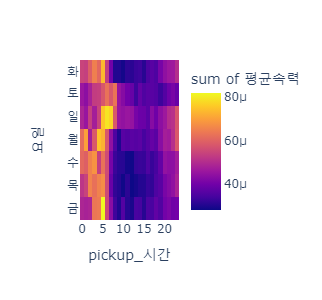

In [18]:
# | title: 요일,시간에 따른 평균속력 시각화        
fig1.show()

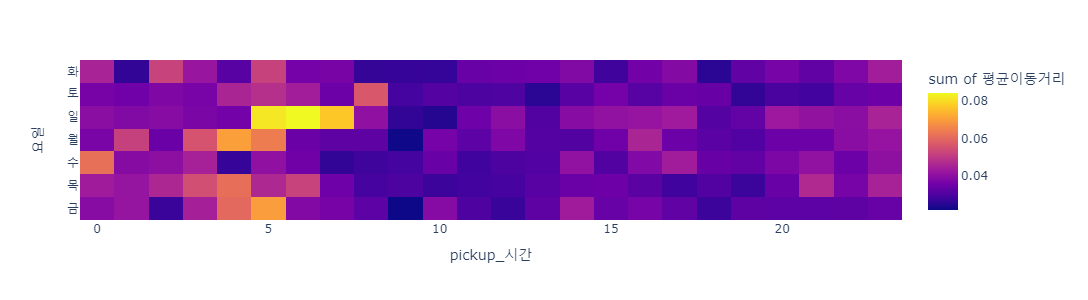

In [14]:
# | title: 요일,시간에 따른 평균이동거리 시각화        
fig2.show()

In [ ]:
## Column {width=50%}

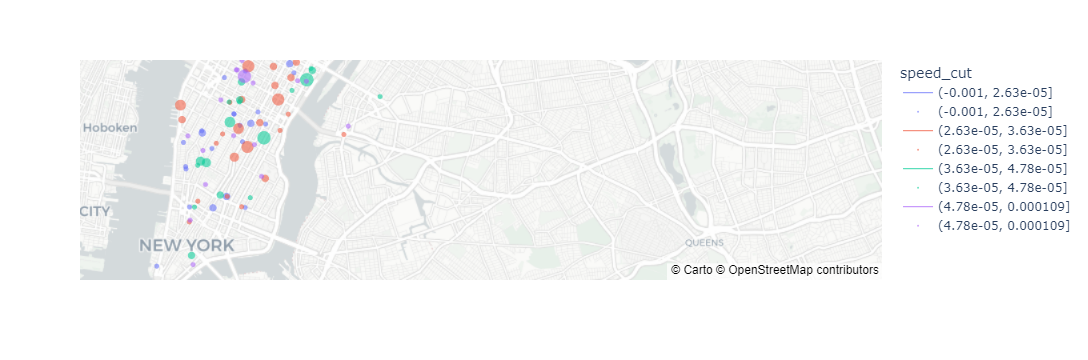

In [15]:
# | title: 속력별 경로 시각화
fig3.show(config={'scrollZoom':False})